In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import re

# Base URL for the UCSD newspaper archives
base_url = "https://library.ucsd.edu/dc/search?f%5Bcollection_sim%5D%5B%5D=UCSD+Guardian&page="

# List to store all the PDF links
pdf_links = []

# Loop through all the pages (1-33) and scrape the PDF links
for page_num in range(1, 34):
    # Construct the URL for the current page
    url = base_url + str(page_num) + "&sort=object_create_dtsi+desc%2C+title_ssi+asc"

    # Make a GET request to the page URL
    response = requests.get(url)

    # Create a BeautifulSoup object from the response HTML
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all the article links on the page
    articles = soup.find_all('div', class_='document-title')

    # Loop through all the articles and extract the PDF link
    for article in articles:
        try:
            # Extract the relative URL for the article
            article_url = article.find('a', class_='original-url')['href']

            # Make a GET request to the article URL
            article_response = requests.get(article_url)

            # Create a BeautifulSoup object from the article response HTML
            article_soup = BeautifulSoup(article_response.content, 'html.parser')

            # Find the PDF link on the article page
            embed_tag = article_soup.find('embed', type=['application/pdf', 'application/x-google-chrome-pdf', 'application/octet-stream'])
            if not embed_tag:
                continue
            pdf_url = embed_tag['original-url']

            # Construct the absolute URL for the PDF file
            pdf_full_url = f"https://library.ucsd.edu{pdf_url}"

            # Extract the date from the PDF URL
            date_str = pdf_url.split('/')[-2]
            year_str = date_str[:4]
            month_str = date_str[4:6]
            day_str = date_str[6:]
            date = f"{year_str}-{month_str}-{day_str}"

            # Create a dictionary with the date and PDF URL
            pdf_info = {
                'date': date,
                'pdf_url': pdf_full_url
            }

            # Append the dictionary to the list of PDF links
            pdf_links.append(pdf_info)
            print(f"PDF link found: {pdf_full_url}")
        except (TypeError, AttributeError):
            # Skip articles that do not have a PDF link or have invalid HTML
            continue
        
# Load the subpage links from the ucsd_subpage_links.json file
with open("ucsd_subpage_links.json", "r") as f:
    subpage_links = json.load(f)
    

In [3]:
import requests
from bs4 import BeautifulSoup
import json
from datetime import datetime
import os

def get_article_links_and_dates(subpage_links):
    if os.path.exists('ucsd_article_pages.json'):
        # Open the JSON file for reading
        with open('ucsd_article_pages.json', 'r') as f:
            article_links = json.load(f)
    else:
        article_links = {}

    # Loop through all the subpages and scrape the PDF links
    for subpage_link in subpage_links:
        # Make a GET request to the subpage URL
        response = requests.get(subpage_link)

        # Create a BeautifulSoup object from the response HTML
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all the PDF links on the page
        articles = soup.find_all('li', class_='dams-sr')

        # Loop through all the PDF links and extract the PDF URL
        for article in articles:
            try:
                # Extract the relative URL for the PDF
                pdf_link_for_article = article.find('a', class_="dams-search-thumbnail-link")
                pdf_url = pdf_link_for_article['href']

                pdf_url = pdf_url.replace("/dc/", "")

                # Construct the absolute URL for the PDF file and add the "_1.pdf" suffix
                pdf_full_url = f"{base_url}{pdf_url.split('?')[0]}/_1.pdf"

                spans = article.find_all('span')

                date_elem = spans[4].text
                # Check if the date element exists and formats the dates (YYYY_mm_dd)
                if date_elem is not None:
                    date_obj = datetime.strptime(date_elem, '%B %d, %Y')
                    formatted_date = date_obj.strftime('%Y_%m_%d')
                    if formatted_date.startswith("2008"):
                        break
                else:
                    raise ValueError("Could not find date element")

                # Add the PDF URL to the article_links dictionary
                if formatted_date not in article_links:
                    article_links[formatted_date] = []

                article_links[formatted_date].append(pdf_full_url)

            except (KeyError, ValueError, AttributeError) as e:
                # Handle any exceptions that occur
                print(f"Error: {e}")
                continue

    # Save the article links dictionary to the JSON file
    with open("ucsd_article_pages.json", "w") as outfile:
        json.dump(article_links, outfile, indent=4)

    return article_links

In [ ]:
article_pages = get_article_links_and_dates(subpage_links)

In [11]:
print(f"There are {len(article_pages)} dates with articles")
total_size = sum([len(article_pages[key]) for key in article_pages])
print(f"There are {total_size} articles to iterate over")

There are 649 dates with articles
There are 649 articles to iterate over


In [ ]:
from helpers.pdf_to_text import extract_pdf_text
from helpers.make_txt_entry import make_txt_entry
import os

school_name = "UCSD"
for date, articles in article_pages.items():
    file_path = "journal_data/txt/"+school_name.replace(" ","_")+"/"+date+".txt"
    if(os.path.exists(file_path)):
        print(f"Date {date} already added.")
    else:
        article_text = extract_pdf_text(articles[0])
            
        make_txt_entry(school_name=school_name, publication_date=date, text=article_text)
        print(f"Date {date} added.")

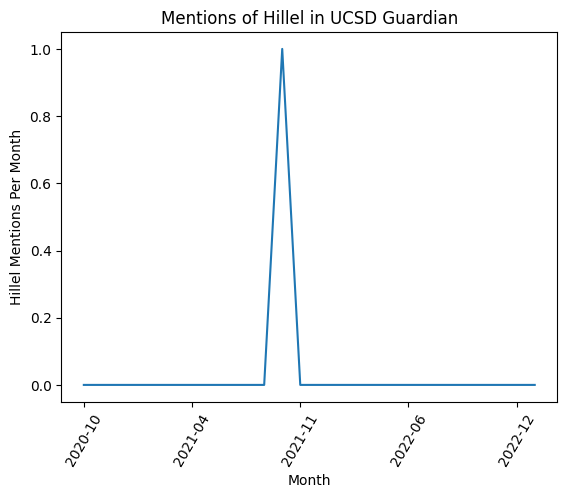

In [ ]:
from helpers.graphers import monthly_grapher
from helpers.queries import hillel_counter

school_name = "UCSD"
newspaper_name = "UCSD Guardian"
school_name_lower = school_name.lower()

UMich_pipeline = []

directory = 'journal_data/txt/' + school_name

monthly_grapher(directory=directory,
                pipeline=UMich_pipeline,
                query=hillel_counter,
                y_label="Hillel Mentions Per Month",
                title="Mentions of Hillel in " + newspaper_name,
                save_path='figures/' + school_name + '/' + school_name + '_hillel_mentions.png')

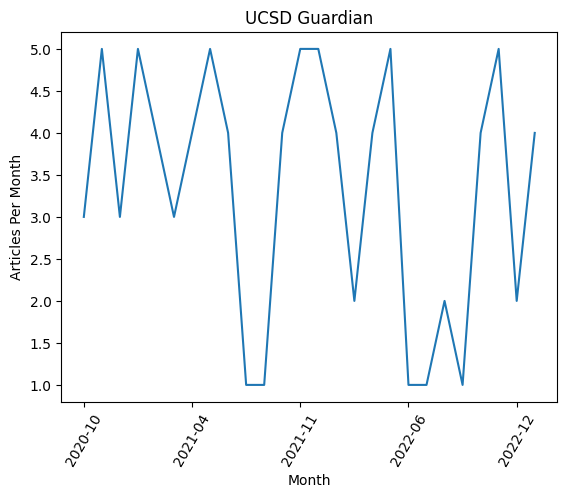

In [ ]:
from helpers.queries import one_query
from helpers.graphers import monthly_grapher

school_name = "UCSD"
newspaper_name = "UCSD Guardian"
school_name_lower = school_name.lower()

directory = 'journal_data/txt/' + school_name

monthly_grapher(directory=directory,
                pipeline=[],
                query=one_query,
                y_label="Articles Per Month",
                title=newspaper_name,
                save_path='figures/' + school_name + '/' + school_name + '_monthly_articles.png')


grouped_data/csv/UCSD_China.csv created.
grouped_data/pkl/monthly/UCSD_China.pkl being created.


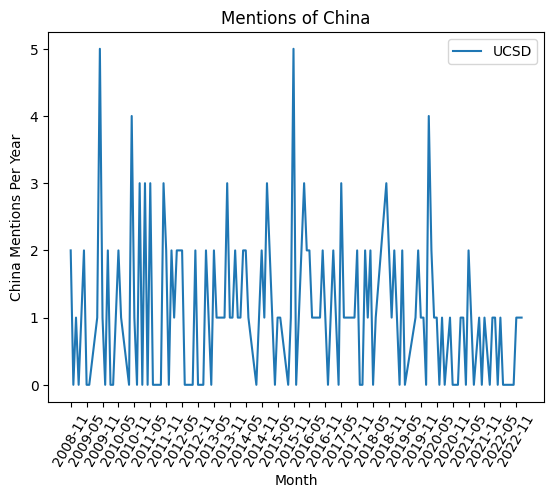

In [1]:
# Hyperparameters to Modify
school_name = 'UCSD'
string = "China"
time_slice = 'monthly'

from helpers.graphers import grapher
from helpers.queries import count_query

school_names = [school_name]
save_pattern = '_'.join(school_names)+'_'+string.replace(' ','_')
grapher(school_names=school_names,
        pipeline=[],
        query=count_query(string),
        y_label=f"{string} Mentions Per Year",
        data_path="grouped_data",
        data_name=save_pattern,
        time_slice=time_slice,
        title=f"Mentions of {string}",
        img_path=f"figures/{school_name}/{save_pattern}_{time_slice}.png")